In [172]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

benchmarks_data_dir = 'TimeSeries\\Benchmarks\\bin\\Debug\\Raw data'

In [173]:
import os

fixtures = os.listdir(benchmarks_data_dir)

print("Found fixtures:\n" if fixtures else "No fixtures were found")

for index, fixture in enumerate(fixtures):
    print("{}). {}".format(index, fixture))

Found fixtures:

0). AllBoxEventSeriesWrapper with bulk write
1). AllBoxEventSeriesWrapper with single write
2). CasTimeSeries with bulk write
3). CasTimeSeries with single write
4). SimpleTimeSeries


In [174]:
import json


def load_json(path):
    print(path)
    with open(path, 'r') as f:
        return json.load(f)

    
def load(fixture):
    fixture_dir = os.path.join(output_dir, fixture)
    
    get_filename = lambda x: os.path.splitext(x)[0]
    load_data = lambda x: load_json(os.path.join(fixture_dir, x))
    
    return {
        get_filename(benchmark): load_data(benchmark)        
        for benchmark in os.listdir(fixture_dir)
    }


fixtures = {
    fixture: load(fixture) for fixture in fixtures
}

print("Loaded data for {} fixtures with {} benchmarks".format(len(fixtures), sum(len(x) for x in fixtures.values())))

print("\nFixtures are:\n")

for fixture in fixtures.keys():
    print(fixture)

TimeSeries\Benchmarks\bin\Debug\Raw data\AllBoxEventSeriesWrapper with bulk write\Read and write.json
TimeSeries\Benchmarks\bin\Debug\Raw data\AllBoxEventSeriesWrapper with bulk write\Read only.json
TimeSeries\Benchmarks\bin\Debug\Raw data\AllBoxEventSeriesWrapper with bulk write\Write only.json
TimeSeries\Benchmarks\bin\Debug\Raw data\AllBoxEventSeriesWrapper with single write\Read and write.json
TimeSeries\Benchmarks\bin\Debug\Raw data\AllBoxEventSeriesWrapper with single write\Read only.json
TimeSeries\Benchmarks\bin\Debug\Raw data\AllBoxEventSeriesWrapper with single write\Write only.json
TimeSeries\Benchmarks\bin\Debug\Raw data\CasTimeSeries with bulk write\Read and write.json
TimeSeries\Benchmarks\bin\Debug\Raw data\CasTimeSeries with bulk write\Read only.json
TimeSeries\Benchmarks\bin\Debug\Raw data\CasTimeSeries with bulk write\Write only.json
TimeSeries\Benchmarks\bin\Debug\Raw data\CasTimeSeries with single write\Read and write.json
TimeSeries\Benchmarks\bin\Debug\Raw data\Ca

In [175]:
def get_total(timing, operations):
    
    new_data = np.zeros((2, len(timing)), dtype=int)
    
    total_time = 0
    total_count = 0
    
    for index, (time, count) in enumerate(zip(timing, operations)):
        total_time += time
        total_count += count
        
        new_data[0][index] = total_time
        new_data[1][index] = total_count
        
    return new_data


for fixture, benchmarks in fixtures.items():
    for benchmark, data in benchmarks.items():
        
        writers_data = data['Writers']
        
        if not writers_data['Latency']: 
            continue
            
        writers_data['Total'] = []
        
        for worker in zip(writers_data['Latency'], writers_data['WritesLength']):
            writers_data['Total'].append(get_total(*worker))

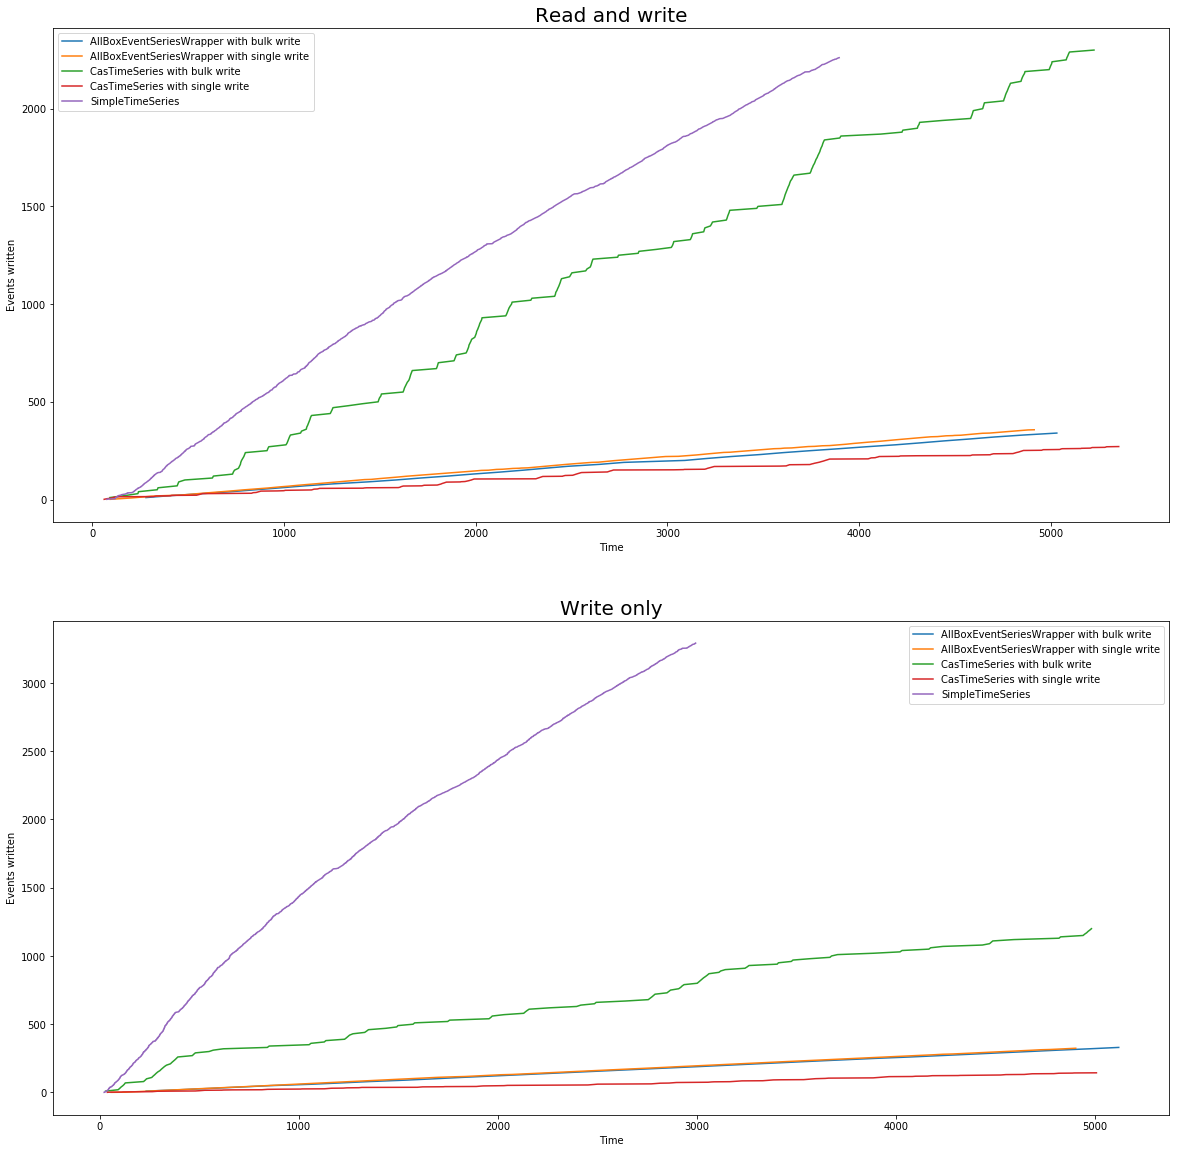

In [176]:
b = ['Read and write', 'Write only']

figure, subplots = plt.subplots(len(b), 1)

figure.set_figheight(20)
figure.set_figwidth(20)

for benchmark, subplot in zip(b, subplots):
    
    legend = []

    for fixture, benchmarks in fixtures.items():    
        total = benchmarks[benchmark]['Writers']['Total']

        if total:
            worker = total[0]
            subplot.plot(worker[0], worker[1])
            legend.append(fixture)

    subplot.set_title(benchmark, fontsize=20)
    subplot.legend(legend)
    subplot.axes.set_xlabel("Time")
    subplot.axes.set_ylabel("Events written")

In [184]:
def plot(workers_stats, title=None):
    show(workers_stats, title, lambda p, w: p.plot(w))


def hist(workers_stats, title=None, nbeans=500):    
    show(workers_stats, title, lambda p, w: p.hist(w, nbeans))
    

def show(workers_stats, title, show_func):
    figure, subplots = plt.subplots(len(workers_stats), 1)

    figure.set_figheight(20)
    figure.set_figwidth(20)
    
    if title:
        figure.suptitle(title, fontsize=18, y=0.94)
    
    for index, (worker, plot) in enumerate(zip(workers_stats, subplots)):
        show_func(plot, worker)
        plot.legend(["Worker #{}".format(index)])

In [181]:
workers = ['Writers']
statistics = ['Latency']
benchmarks = ['Read and write']

def show_data(func):
    for fixture, loaded_benchmarks in fixtures.items():
        for benchmark in benchmarks:
            data = loaded_benchmarks[benchmark]
            for worker in workers:
                for statistic in statistics:
                    key_data = data[worker][statistic]
                    if (key_data):
                        title = "{}\n{}\n{} - {}".format(fixture, benchmark, worker, statistic)
                        func(key_data, title=title)

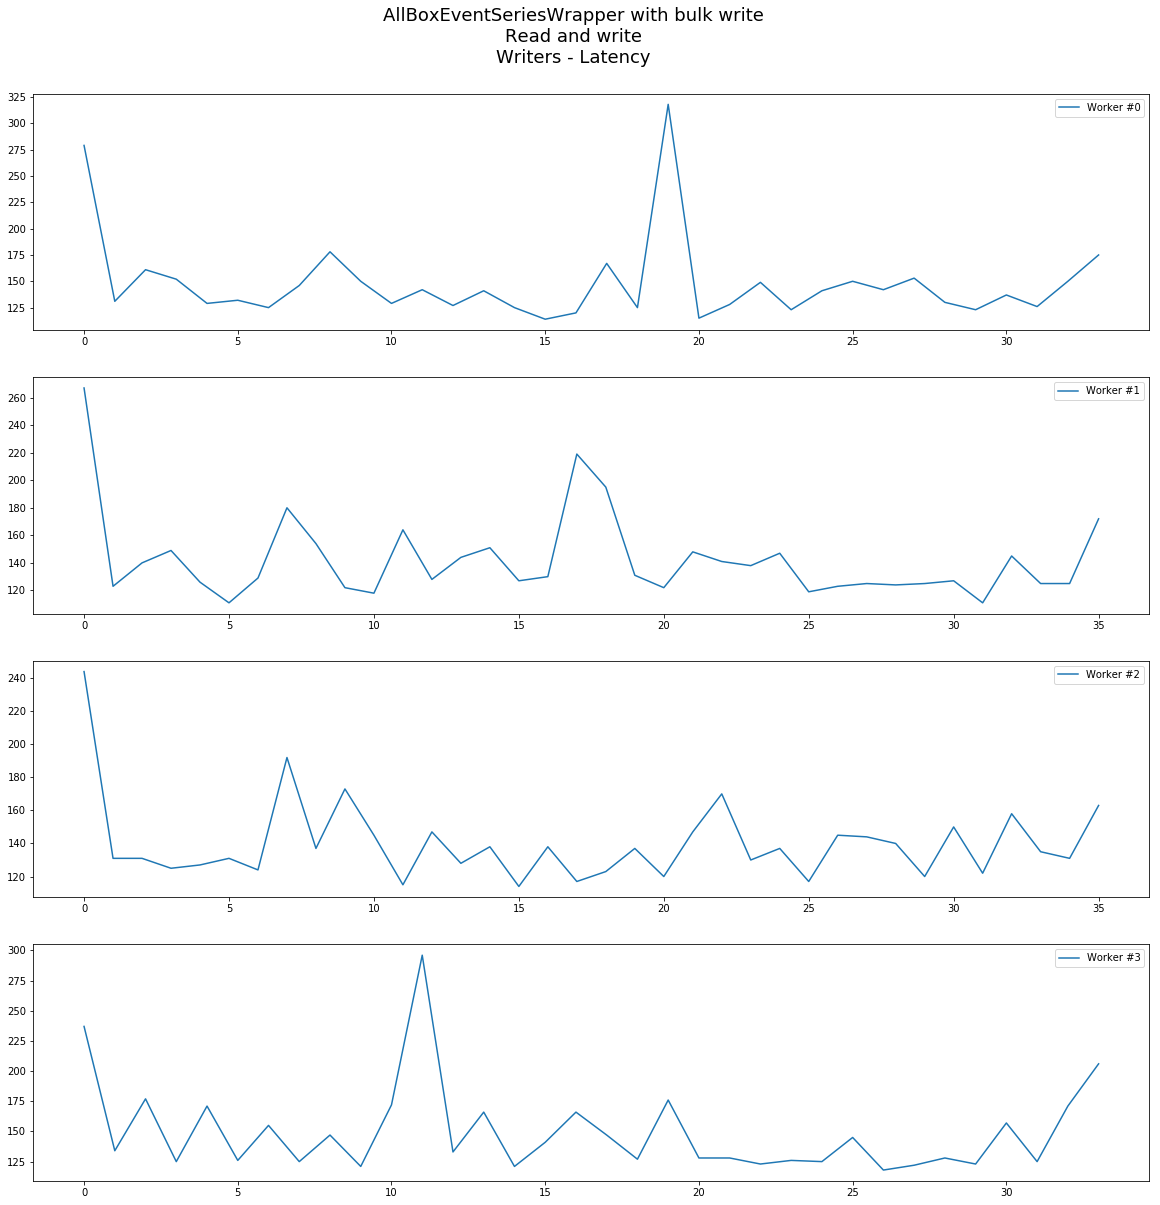

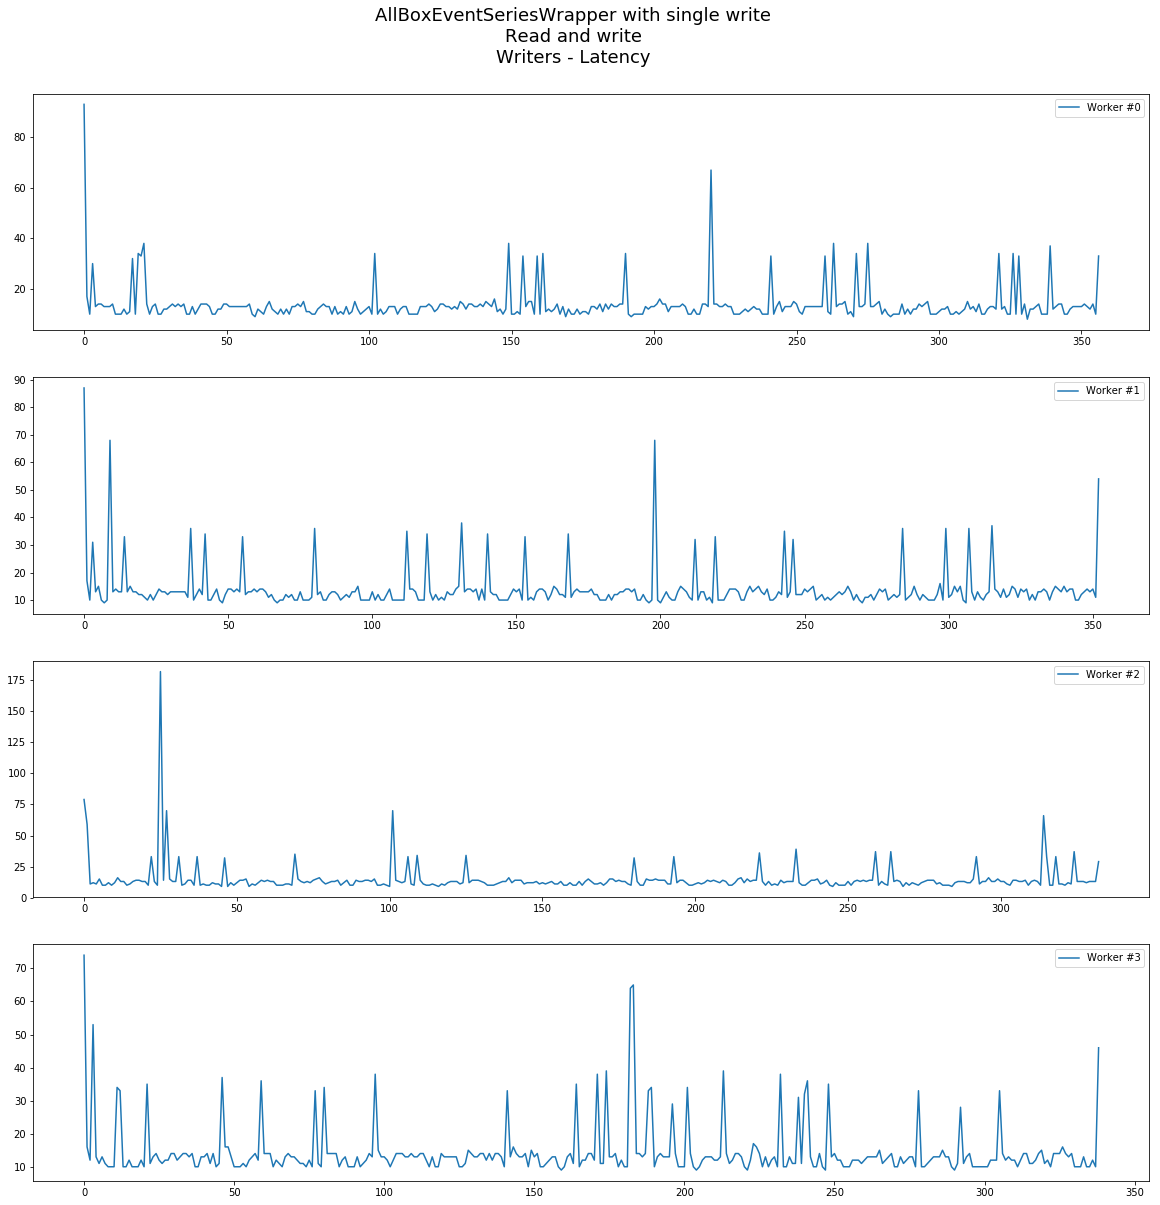

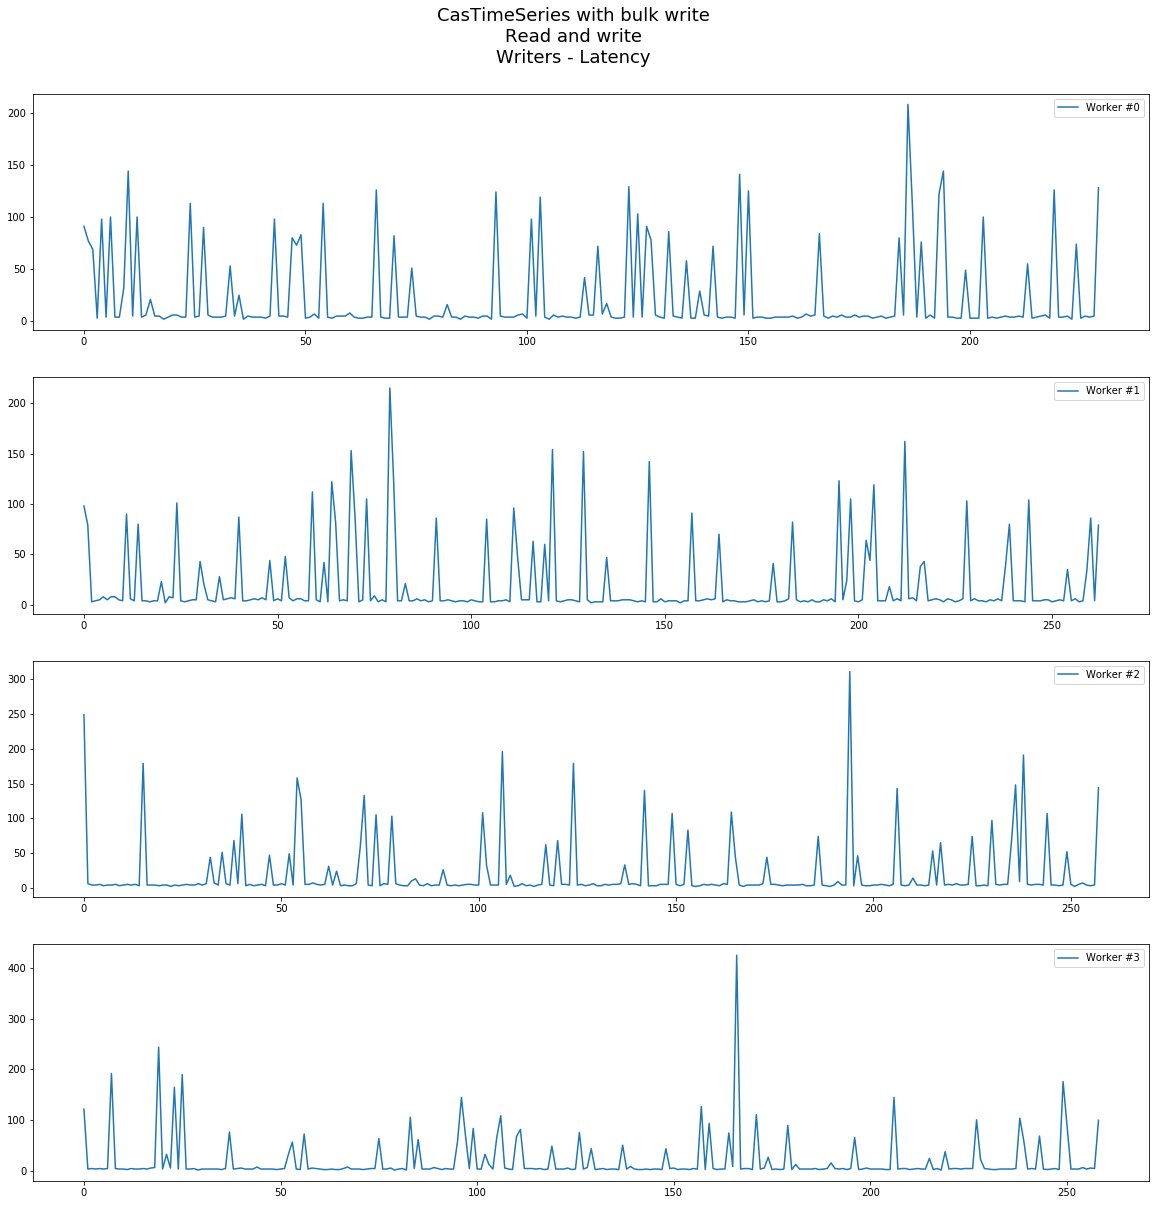

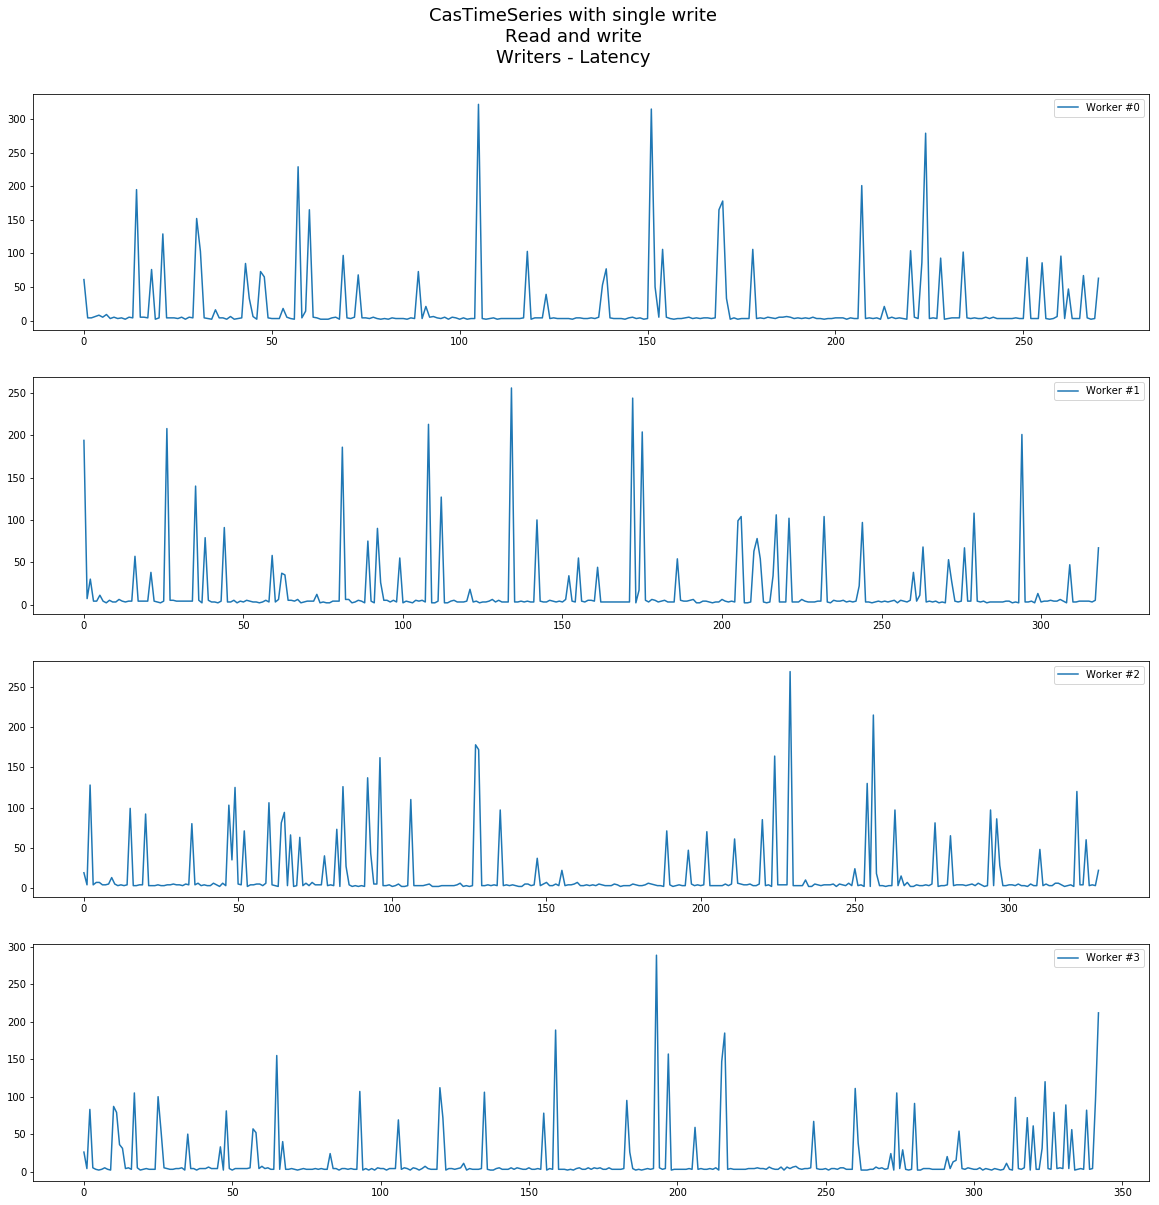

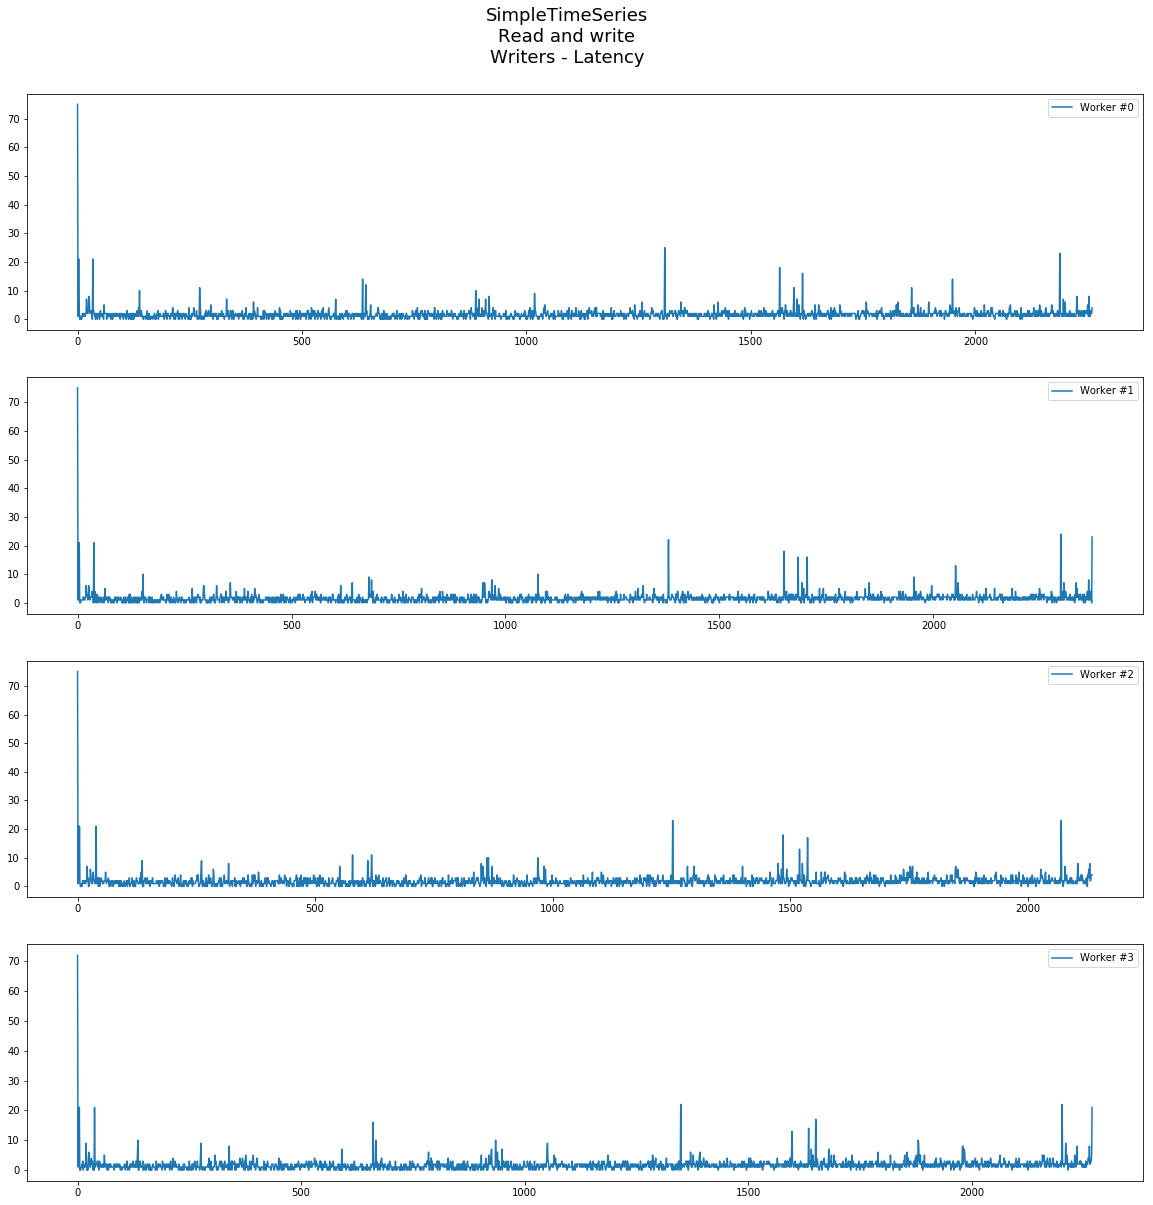

In [182]:
show_data(plot)

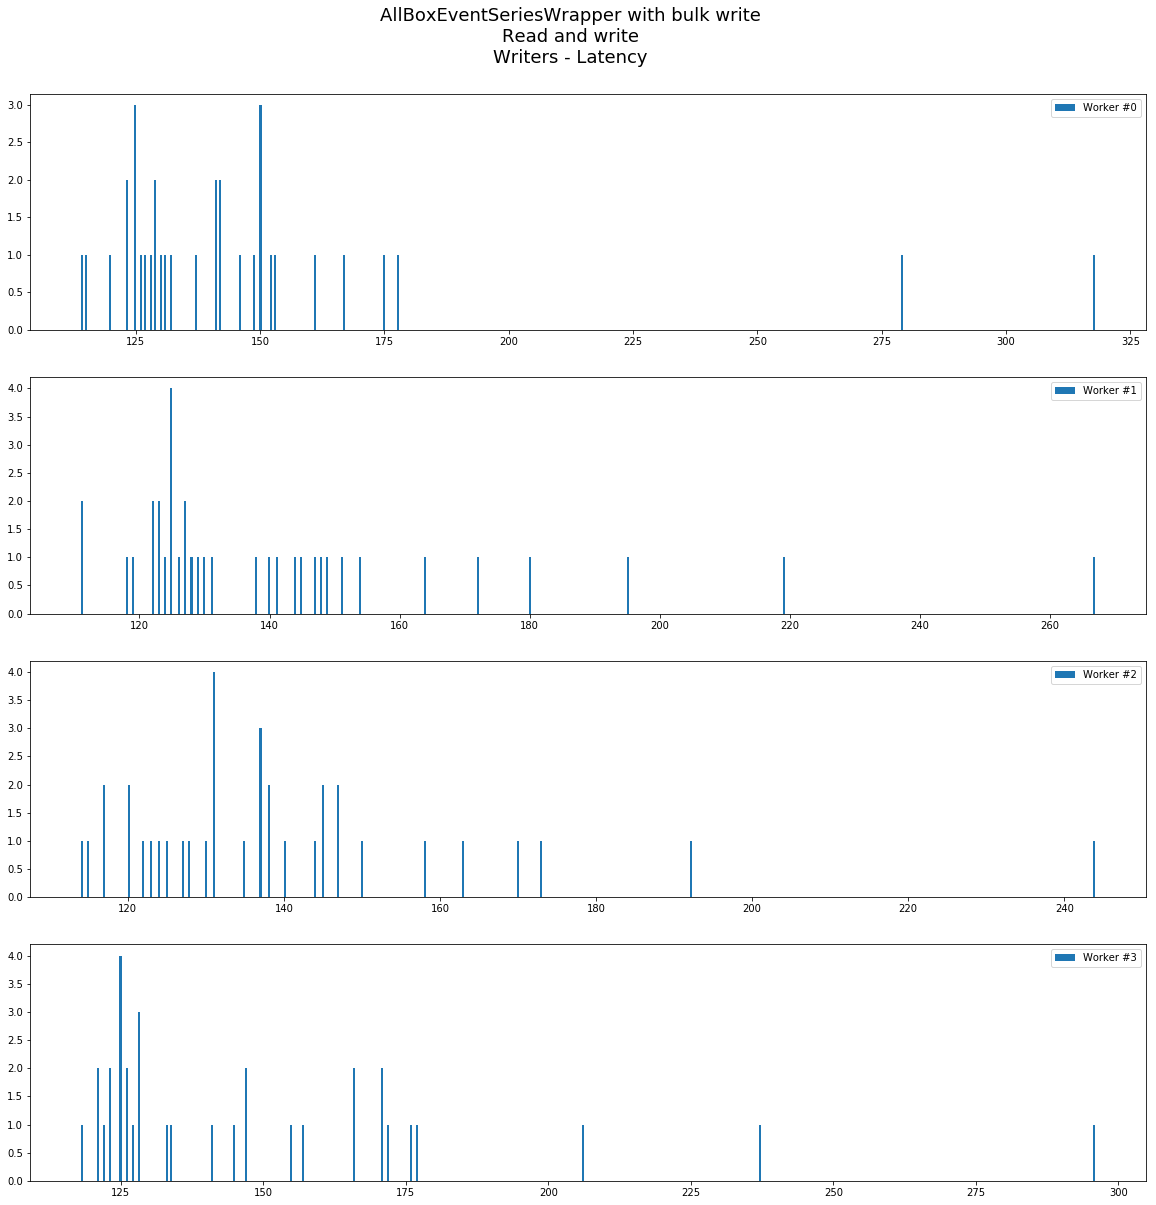

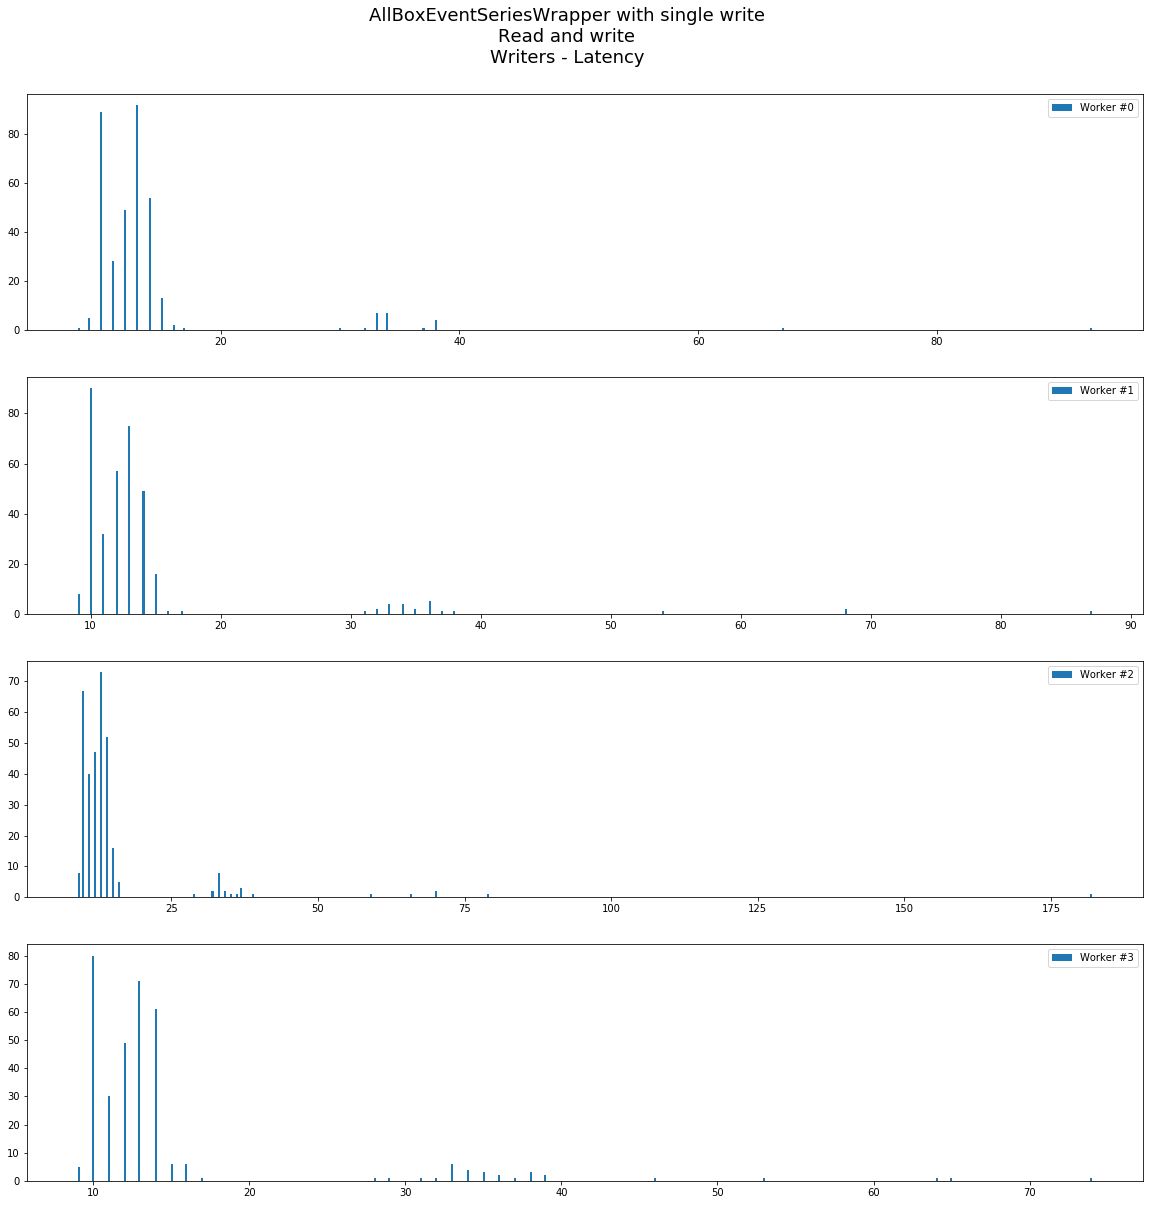

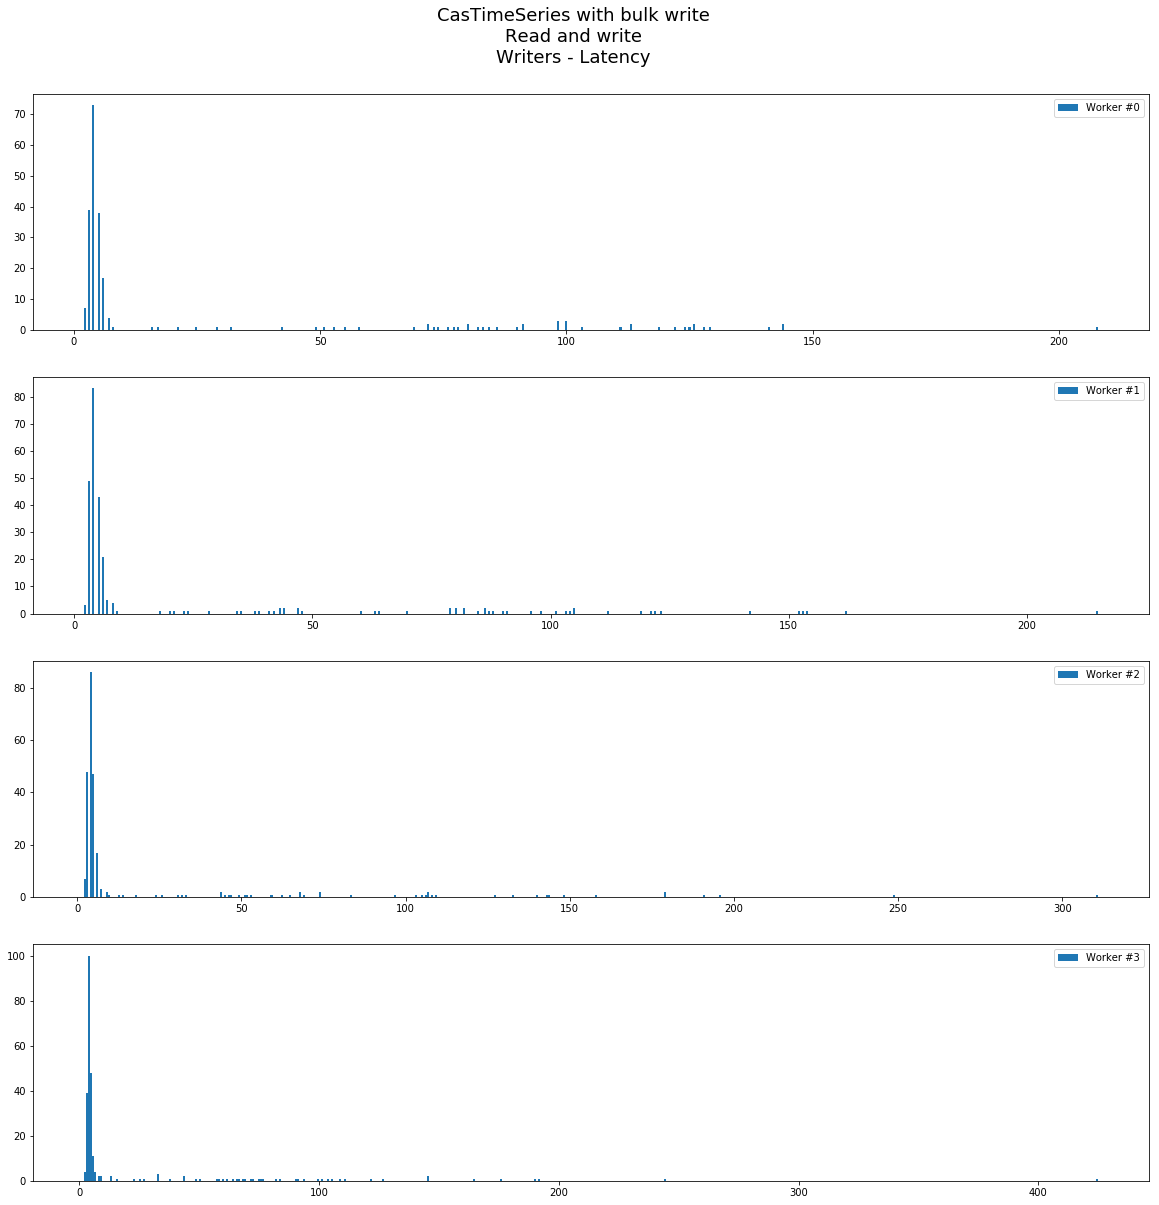

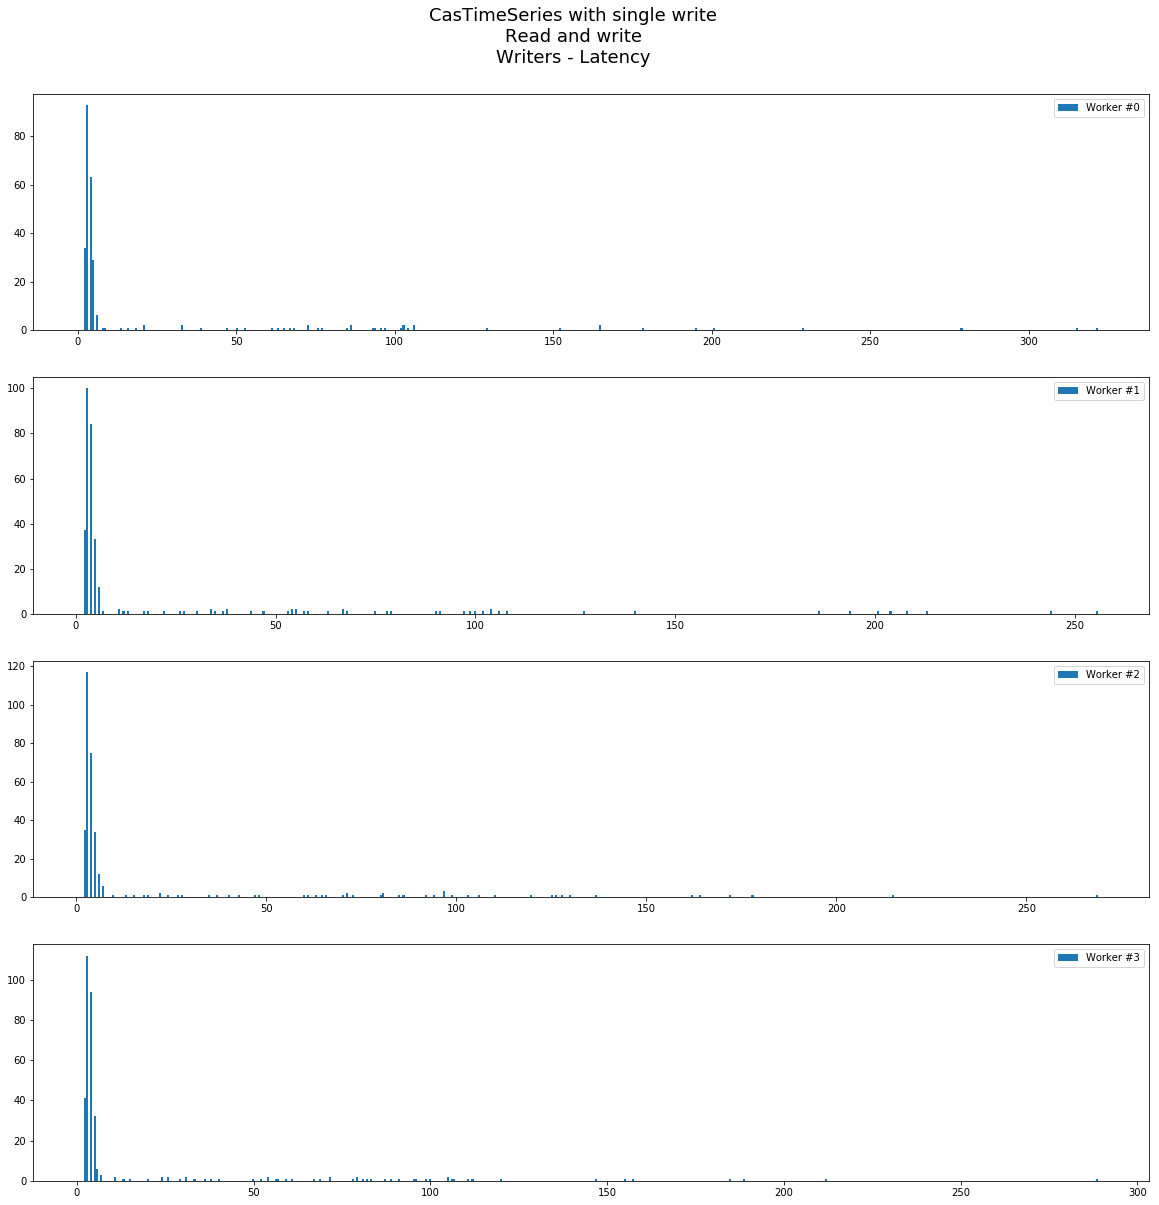

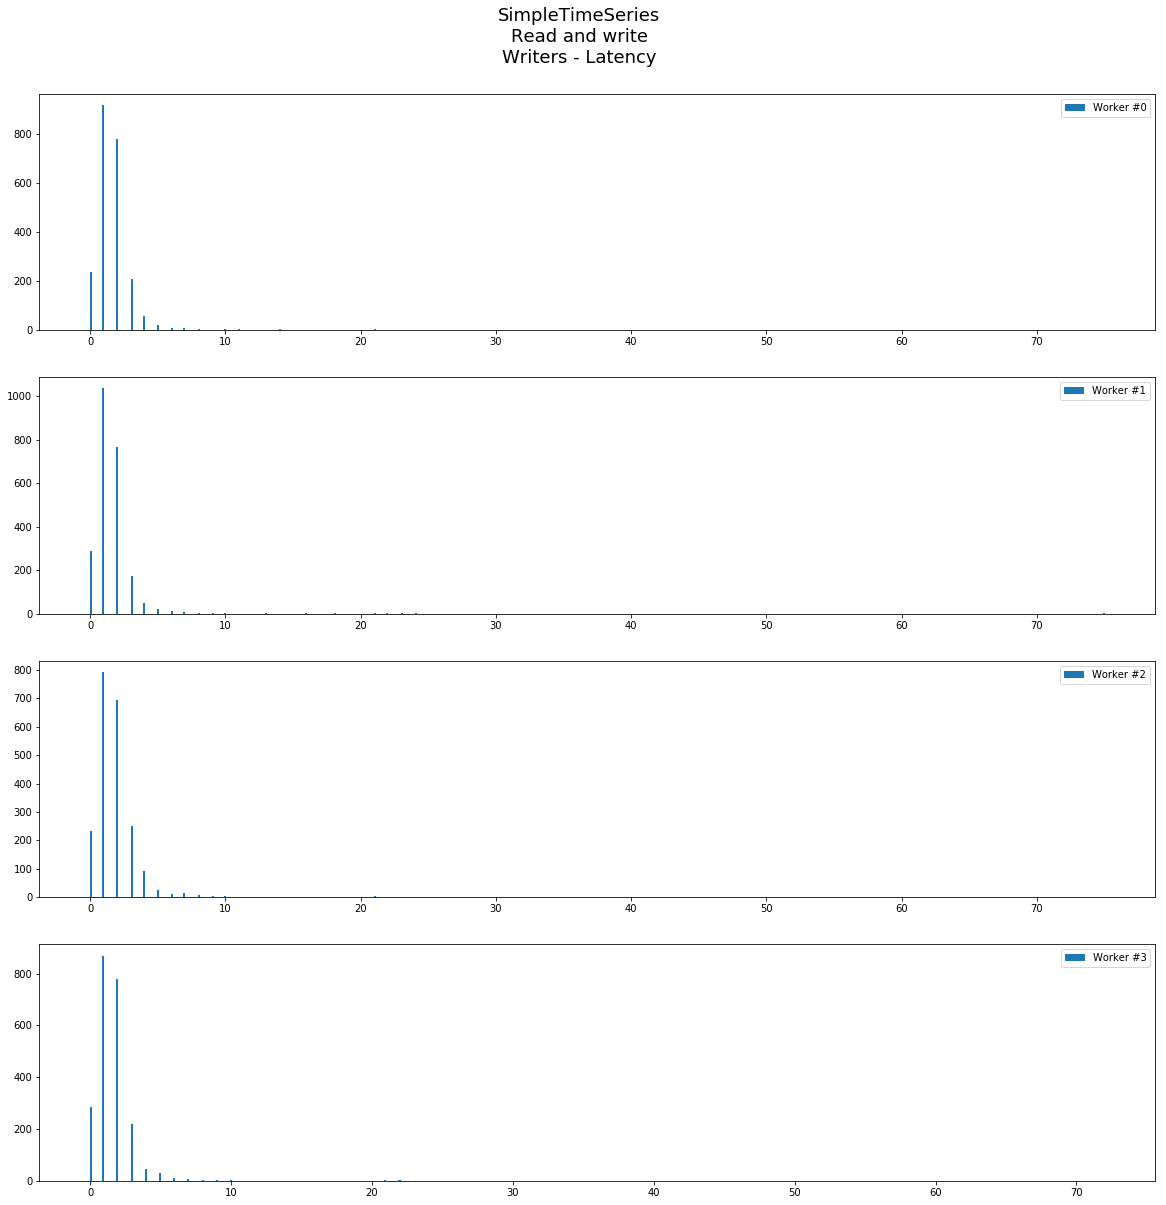

In [185]:
show_data(hist)